In [ ]:
import h5py
import pickle
import numpy as np
import matplotlib.pyplot as plt

#### Data Extraction
In this section, we extract the `pose`, `velocity`, `acceleration`, `time`, `force amplitude` and `period` from each continuation simulation file. This dataset was created for **frequencies** ranging from $10.0Hz$ to $24.0Hz$ in steps of $0.2Hz$, where for each, the continuation parameter was the **forcing amplitude**.

The output is in **modal coordinates**.

In [2]:
filename='frequency_step_frequency_'
path='results'

In [3]:
# Store ML data
ml_data = {}

# Loop over all files in directory
for i in np.arange(10.0, 24.1, 0.2):
    # Open new file
    file = f"{path}/{filename}{i:.03f}.h5"

    # -------------------------- READ CONTINUATION FILES
    # NOTE: COL -> Number of Periodic Solutions, ROW -> Number of Solution Points
    data = h5py.File(str(file), "r")
    pose = data["/Config_Time/POSE"][:].squeeze()
    vel = data["/Config_Time/VELOCITY"][:].squeeze()
    acc = data["/Config_Time/ACCELERATION"][:].squeeze()
    time = data["/Config_Time/Time"][:].T
    F = data["/Force_Amp"][:]
    T = data["/T"][:]
    # Close file
    data.close()

    # ------------------------------- COLLECT DATA
    ml_data[f"{i:.03f}"] = {
        "pose": pose,
        "vel": vel,
        "acc": acc,
        "time": time,
        "F": F,
        "T": T
    }

# SAVE DATA
with open(f"{path}/data.pkl", "wb") as f:
    pickle.dump(ml_data, f)

In [4]:
pose.shape, vel.shape, acc.shape, time.shape, F.shape, T.shape

((301, 39), (301, 39), (301, 39), (301, 39), (39,), (39,))

#### Dataset Visualization

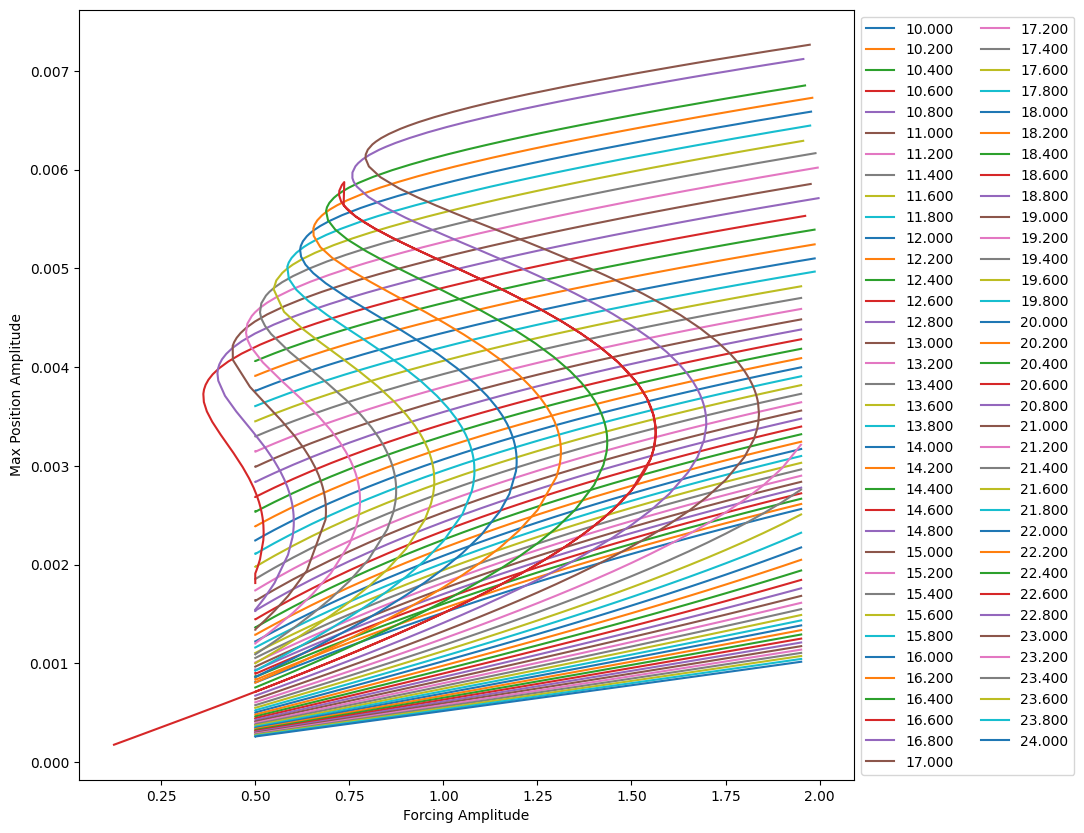

In [5]:
f, a = plt.subplots(figsize=(10, 10))
a.set(xlabel="Forcing Amplitude", ylabel="Max Position Amplitude")

# Color cycle for different files
color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = color_cycle * ((len(ml_data.keys()) // len(color_cycle)) + 1)

# Plot solutions
line_objects = []  # Collect all line objects for cursor interaction
offsets = {}  # Store offsets for each segment
total_points = 0  # Total number of points plotted

for data, color in zip(ml_data.items(), color_cycle):
    k, v = data
    pose_time = v["pose"]
    F = v["F"]

    n_solpoints = len(F)
    amp = np.zeros(n_solpoints)
    for i in range(n_solpoints):
        amp[i] = np.max(np.abs(pose_time[:, i])) / 1.0

    (line,) = a.plot(
        F / 1.0,
        amp,
        marker="none",
        linestyle="solid",
        color=color,
        label=k,
    )
    offsets[line] = total_points
    total_points += len(F)
    line_objects.append(line)

a.legend(ncols=2, bbox_to_anchor=(1.0, 1.0))

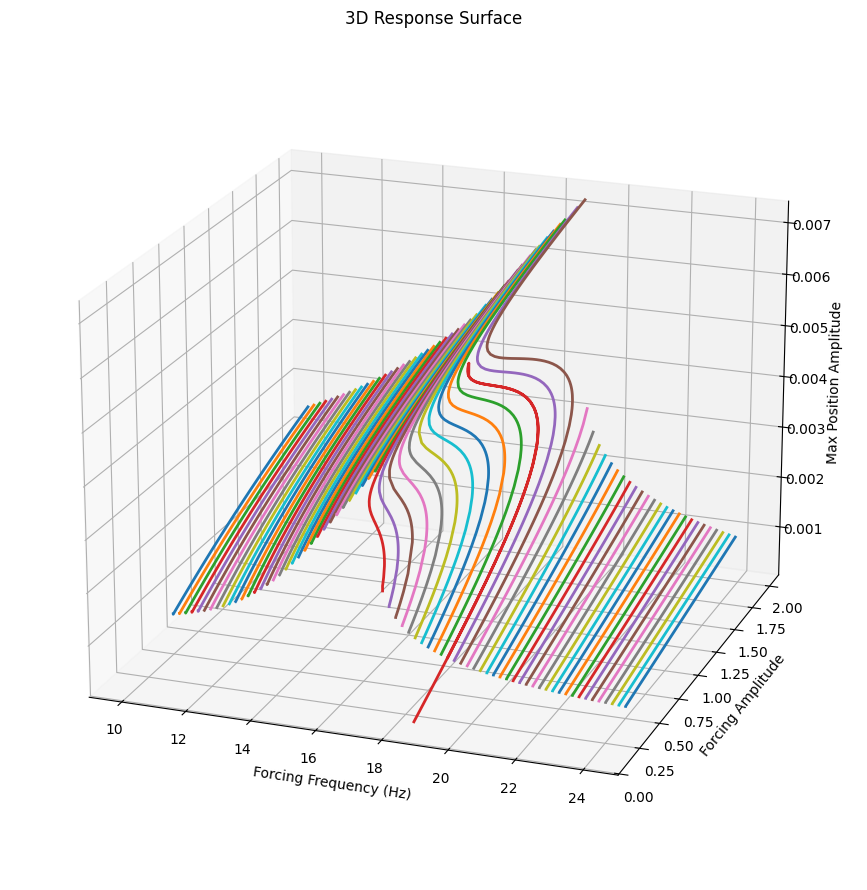

In [6]:
# Create 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("Forcing Frequency (Hz)")
ax.set_ylabel("Forcing Amplitude")
ax.set_zlabel("Max Position Amplitude")

# Define colors for different continuation types
frc_color = "blue"  # Frequency continuation (FRC)
scurve_color = "orange"  # Amplitude continuation (S-curves)

# Plot solutions from all files
for k, v in ml_data.items():
    pose_time = v["pose"]
    color = scurve_color
    
    T = v["T"]
    freq = 1 / (T * 1.0)  # Convert period to frequency
    F = v["F"]

    n_solpoints = len(F)
    amp = np.zeros(n_solpoints)
    for i in range(n_solpoints):
        amp[i] = np.max(np.abs(pose_time[:, i])) / 1.0

    # Plot the 3D curve (solid lines only, no stability info)
    ax.plot(freq, F / 1.0, amp, linestyle="-", linewidth=2)

# Customize the plot
ax.grid(True, alpha=0.3)

# Set viewing angle for better visualization
ax.view_init(elev=20, azim=-70)

plt.title("3D Response Surface")
plt.tight_layout()

#### LNN Dataset Formation

In [7]:
SPLIT=0.2
seed=42 # for reproducibility

In [8]:
with open(f"{path}/data.pkl", "rb") as f:
    ml_data = pickle.load(f)
    
    # Collect data shapes
    n_curves = len(ml_data.keys())
    x_train, dx_train, ddx_train, t_train, F_train, T_train = [], [], [], [], [], []
    x_test, dx_test, ddx_test, t_test, F_test, T_test = [], [], [], [], [], []
    
    # Create datasets
    for k, v in ml_data.items():
        assert v["pose"].shape == v["vel"].shape == v["acc"].shape == v["time"].shape, f"Data shape mismatch for key {k}"
        assert v["F"].shape == v["T"].shape, f"Data shape mismatch for key {k}"

        n_time_steps_per_point = v["time"].shape[0]
        n_points_per_curve = v["pose"].shape[1]

        # Split data into training and testing sets
        rng = np.random.default_rng(seed=seed)
        shuffle = rng.permutation(n_points_per_curve)
        seed += 1 # Increment seed for next shuffle
        
        train_indices = shuffle[:int(n_points_per_curve * (1 - SPLIT))]
        test_indices = shuffle[int(n_points_per_curve * (1 - SPLIT)):]
        
        _x_train = v["pose"][:, train_indices].flatten()
        _dx_train = v["vel"][:, train_indices].flatten()
        _ddx_train = v["acc"][:, train_indices].flatten()
        _t_train = v["time"][:, train_indices].flatten()
        _F_train = v["F"][train_indices]
        _T_train = v["T"][train_indices]
        _x_test = v["pose"][:, test_indices].flatten()
        _dx_test = v["vel"][:, test_indices].flatten()
        _ddx_test = v["acc"][:, test_indices].flatten()
        _t_test = v["time"][:, test_indices].flatten()
        _F_test = v["F"][test_indices]
        _T_test = v["T"][test_indices]
        
        # Append to training data
        reps_train = _x_train.shape[0] // _F_train.shape[0]
        x_train.append(_x_train)
        dx_train.append(_dx_train)
        ddx_train.append(_ddx_train)
        t_train.append(_t_train)
        F_train.append(np.tile(_F_train, reps=(1, reps_train)).flatten())
        T_train.append(np.tile(_T_train, reps=(1, reps_train)).flatten())

        # Append to testing data
        reps_test = _x_test.shape[0] // _F_test.shape[0]
        x_test.append(_x_test)
        dx_test.append(_dx_test)
        ddx_test.append(_ddx_test)
        t_test.append(_t_test)
        F_test.append(np.tile(_F_test, reps=(1, reps_test)).flatten())
        T_test.append(np.tile(_T_test, reps=(1, reps_test)).flatten())

    # Convert lists to numpy arrays
    x_train = np.concatenate(x_train)
    dx_train = np.concatenate(dx_train)
    ddx_train = np.concatenate(ddx_train)
    t_train = np.concatenate(t_train)
    F_train = np.concatenate(F_train)
    T_train = np.concatenate(T_train)
    x_test = np.concatenate(x_test)
    dx_test = np.concatenate(dx_test)
    ddx_test = np.concatenate(ddx_test)
    t_test = np.concatenate(t_test)
    F_test = np.concatenate(F_test)
    T_test = np.concatenate(T_test)
    
    # Collect data
    train_data = np.concatenate(
        (x_train[:, np.newaxis], dx_train[:, np.newaxis], ddx_train[:, np.newaxis], t_train[:, np.newaxis], F_train[:, np.newaxis], T_train[:, np.newaxis]), axis=1
    )
    test_data = np.concatenate(
        (x_test[:, np.newaxis], dx_test[:, np.newaxis], ddx_test[:, np.newaxis], t_test[:, np.newaxis], F_test[:, np.newaxis], T_test[:, np.newaxis]), axis=1
    )
    
    info = {
        "train_data_shape": train_data.shape,
        "test_data_shape": test_data.shape,
        "n_curves": n_curves,
        "Shapes" : "[Samples, Features: x, dx, ddx, t, F, T]",
        "qmax": x_train.max(),
        "qmin": x_train.min(),
        "qdmax": dx_train.max(),
        "qdmin": dx_train.min(),
        "qddmax": ddx_train.max(),
        "qddmin": ddx_train.min(),
    }

In [9]:
# Format dataset for LNN
# Position, velocity & total forcing conditions
train_x = train_data[:, :2]
train_dx = train_data[:, 1:3]
train_f = train_data[:, 3:]

test_x = test_data[:, :2]
test_dx = test_data[:, 1:3]
test_f = test_data[:, 3:]

train_data = train_x, train_f, train_dx
test_data = test_x, test_f, test_dx

In [10]:
train_data[0].shape, test_data[0].shape, train_data[1].shape, test_data[1].shape, train_data[2].shape, test_data[2].shape

((805175, 2), (207389, 2), (805175, 3), (207389, 3), (805175, 2), (207389, 2))

#### LNN


In [17]:
# Load necessary packages
import jax
import jax.numpy as jnp

# NN packages
import optax

# Data packages
import matplotlib.pyplot as plt

from MDOF_LNN import Damped_Split_LNN, Split_MLP, Damped_Split_LNN

In [12]:
mnn_settings = {
    'name': 'MNN',
    'units': 16,
    'layers': 2,
    'input_shape': 2,
    'train_batch_size': 128,
    'test_batch_size': 64,
    'shuffle': True,
    'seed': 69
    }

knn_settings = {
    'name': 'KNN',
    'units': 16,
    'layers': 2,
    'input_shape': 2,
    }

dnn_settings = {
    'name': 'DNN',
    'units': 16,
    'layers': 2,
    'input_shape': 1,
    }

results_path = 'MDOF_LNN'
file_name='MKD'

lr = 1e-03
mnn_optimizer = optax.adam(lr)
knn_optimizer = optax.adam(lr)
dnn_optimizer = optax.adam(lr)
epochs = 20
show_every = 10

In [13]:
results = Damped_Split_LNN.load_model(f"./MDOF_LNN/MKD/Iter_400/model.pkl")
mnn_settings = results['mnn_settings']
knn_settings = results['knn_settings']
dnn_settings = results['dnn_settings']
info = results['info']

In [14]:
a = Damped_Split_LNN(
    mnn_module=Split_MLP, 
    knn_module=Split_MLP,       
    dnn_module=Split_MLP, 
    mnn_settings=mnn_settings,
    knn_settings=knn_settings,
    dnn_settings=dnn_settings, 
    mnn_optimizer=mnn_optimizer, 
    knn_optimizer=knn_optimizer, 
    dnn_optimizer=dnn_optimizer, 
    info=info, 
    activation=jax.nn.tanh)

# Start training LNN
# results = None
_, _, _ = a.gather()

In [ ]:
# Standard loss
for _ in range(20):
    results = a.train(train_data, test_data, results, epochs=epochs, show_every=show_every)
    a.save_model(results, model_name=f"Iter_{results['last_epoch']}", folder_name=f"{results_path}/{file_name}")
print(f"Final loss: {results['best_loss']}")

In [18]:
def evaluate(results, n_points=40, file_name="MKD"):
        _, pred_energy = a._predict(results)
        limq1, limq2, limqd1, limqd2 = info["qmin"], info["qmax"], info["qdmax"], info["qdmin"]

        qa, qda = jnp.linspace(limq1, limq2, n_points), jnp.linspace(
            limqd1, limqd2, n_points)
        qaa, qdaa = jnp.meshgrid(qa, qda)

        # Get all energy functions here
        M, K, D = pred_energy(qaa.reshape(-1, 1, 1), qdaa.reshape(-1, 1, 1))
        L = M - K

        fig = plt.figure(figsize=(12, 12), tight_layout=True)
        fig.suptitle(f"Final Test Loss: {results['best_loss']:.3e}")

        # --------------------------------- FUNCTIONS

        # -------------------------------- Lagrangian
        ax = fig.add_subplot(221, projection="3d")
        m = ax.plot_surface(qaa, qdaa, L.reshape(qaa.shape), cmap="RdGy", lw=0)
        ax.set_xlabel("q")
        ax.set_ylabel(r"$\dot{q}$")
        ax.set_zlabel(r"$\mathcal{L}_{NN}$", fontsize=16, labelpad=3)
        ax.set_title(f"Lagrangian")
        fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

        # ---------------------------------- Mass
        ax = fig.add_subplot(222, projection="3d")
        m = ax.plot_surface(qaa, qdaa, M.reshape(qaa.shape), cmap="PiYG", lw=0)
        ax.set_xlabel("q")
        ax.set_ylabel(r"$\dot{q}$")
        ax.set_zlabel(r"$\mathcal{M}_{NN}$", fontsize=16, labelpad=3)
        ax.set_title("Mass")
        fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

        # ---------------------------------- Stiffness
        ax = fig.add_subplot(223, projection="3d")
        m = ax.plot_surface(qaa, qdaa, K.reshape(qaa.shape), cmap="PiYG", lw=0)
        ax.set_xlabel("q")
        ax.set_ylabel(r"$\dot{q}$")
        ax.set_zlabel(r"$\mathcal{K}_{NN}$", fontsize=16, labelpad=3)
        ax.set_title("Stiffness")
        fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)

        # ---------------------------------- Damping
        ax = fig.add_subplot(224, projection="3d")
        m = ax.plot_surface(qaa, qdaa, D.reshape(qaa.shape), cmap="PiYG", lw=0)
        ax.set_xlabel("q")
        ax.set_ylabel(r"$\dot{q}$")
        ax.set_zlabel(r"$\mathcal{D}_{NN}$", fontsize=16, labelpad=3)
        ax.set_title("Damping")
        fig.colorbar(m, ax=ax, shrink=0.3, pad=0.1)
        # fig.savefig(f"./Split_LNN/{file_name}-LD.png")

        # --------------------------------- ENERGIES --------------------------------- #
        fig = plt.figure(figsize=(10, 10), tight_layout=True)

        # --------------------------------- Stiffness
        K = jax.vmap(jax.jacrev(pred_energy, 0))(
            qa.reshape(-1, 1, 1), qda.reshape(-1, 1, 1))[1]
        ax = fig.add_subplot(221)
        ax.plot(qa, -K.squeeze(), lw=0.8)
        ax.set_title("Predicted Spring Force")
        ax.set_xlabel(r"$q \ (m)$", fontsize=12)
        ax.set_ylabel(
            r"$-\frac{\partial \mathcal{L}_{NN}}{\partial q}$", fontsize=18, labelpad=7)

        # ---------------------------------- Damping
        C = jax.vmap(jax.jacrev(pred_energy, 1))(
            qa.reshape(-1, 1, 1), qda.reshape(-1, 1, 1))[2]
        ax = fig.add_subplot(222)
        ax.plot(qda, C.squeeze(), lw=0.8)
        ax.set_title("Predicted Damping Force")
        ax.set_ylabel(r"$\dot{q} \ (m \ s^{-1})$ ", fontsize=12)
        ax.set_ylabel(
            r"$\frac{\partial \mathcal{D}_{NN}}{\partial \dot{q}}$", fontsize=18, labelpad=7)

        # ----------------------------------- Mass
        M = jax.vmap(jax.hessian(pred_energy, 1))(
            qa.reshape(-1, 1, 1), qda.reshape(-1, 1, 1))[0]
        ax = fig.add_subplot(223)
        m = ax.plot(qa, M.reshape(qda.shape), lw=0.8)
        ax.set_xlabel(r"$q$")
        ax.set_ylabel(
            r"$\frac{\partial}{\partial t}(\frac{\partial \mathcal{L}_{NN}}{\partial q})$", fontsize=16, labelpad=3)
        ax.set_title(f"Mass")

        ax = fig.add_subplot(224)
        m = ax.plot(qda, M.reshape(qda.shape), lw=0.8)
        ax.set_xlabel(r"$\dot{q}$")
        ax.set_ylabel(
            r"$\frac{\partial}{\partial t}(\frac{\partial \mathcal{L}_{NN}}{\partial q})$", fontsize=16, labelpad=3)
        ax.set_title(f"Mass")

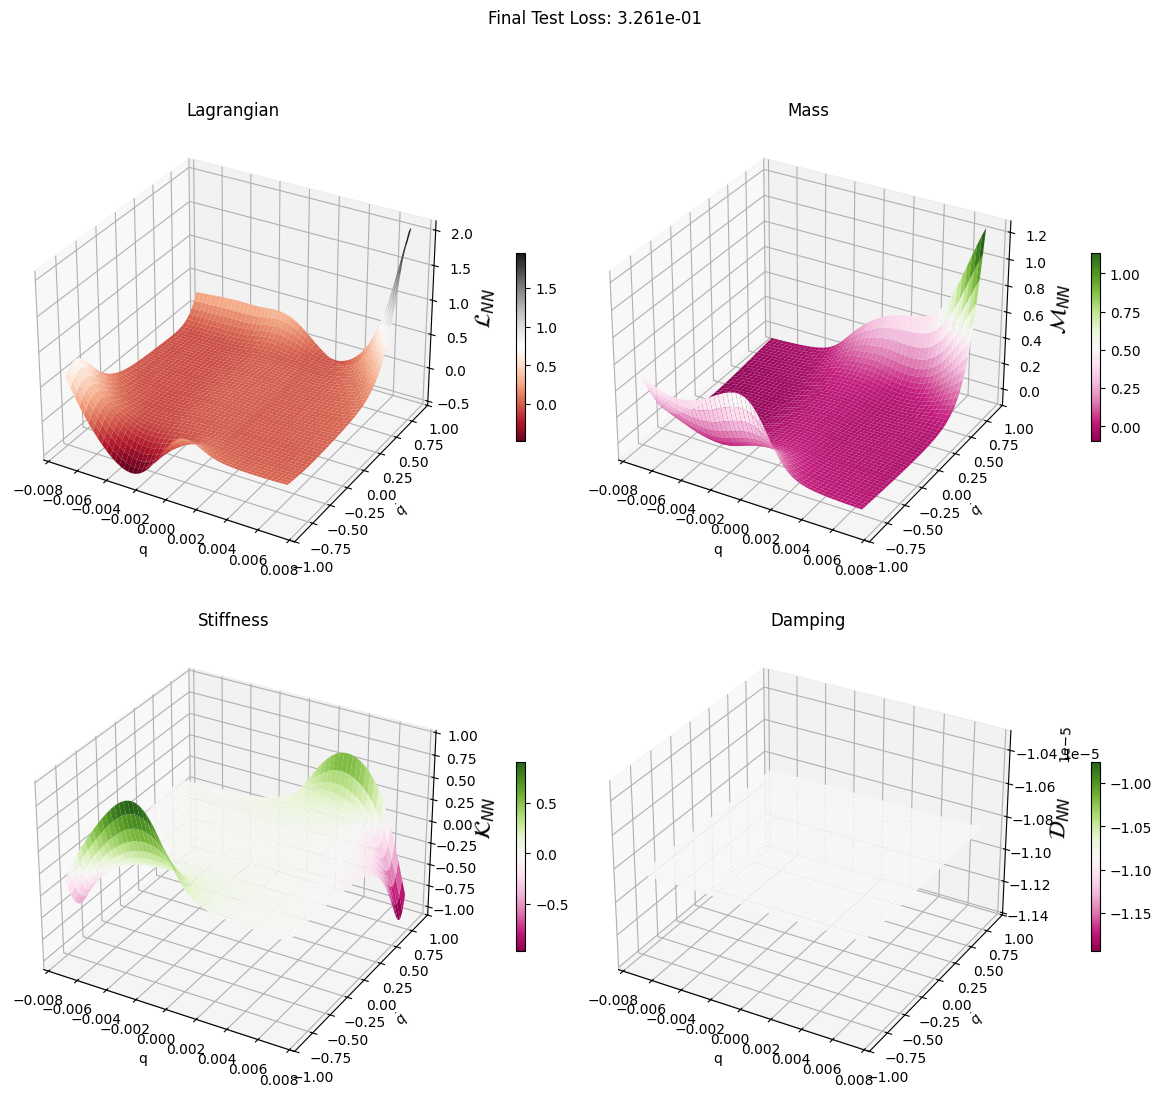

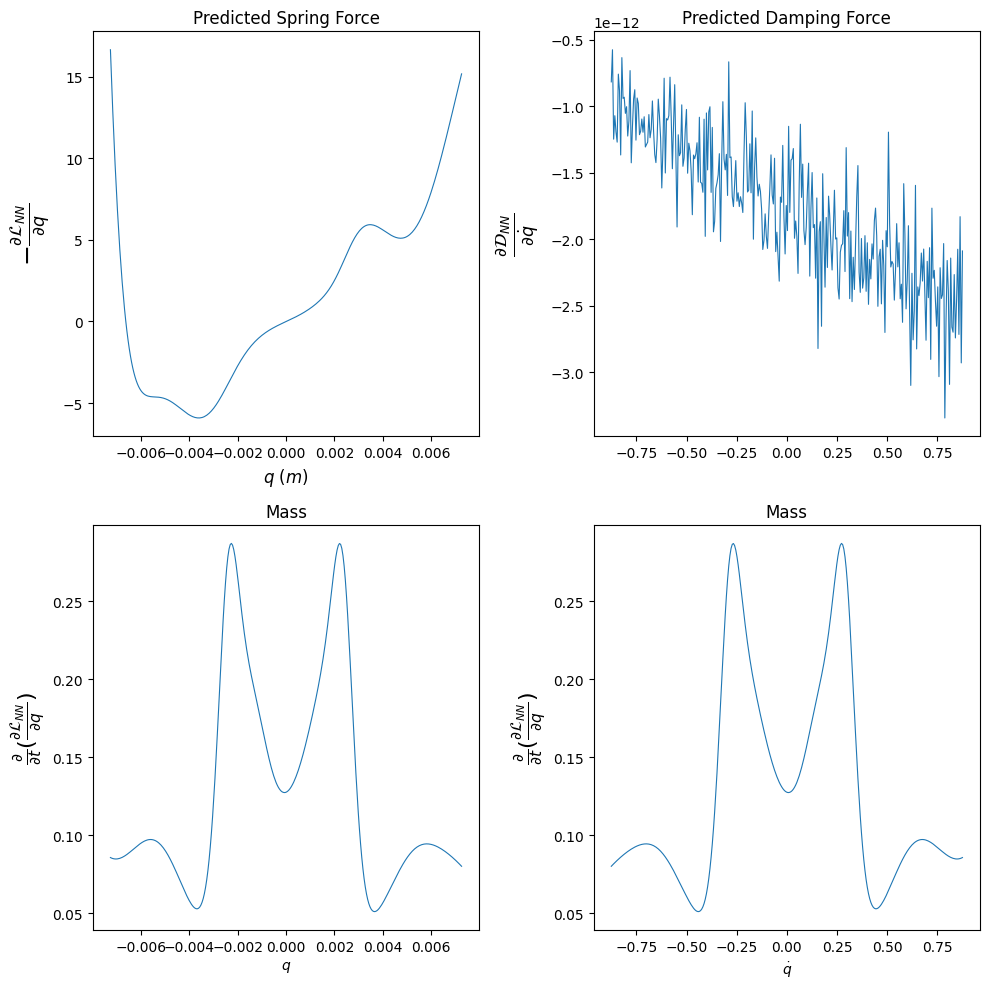

In [20]:
evaluate(results=results, n_points=300, file_name=file_name)